In [151]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset ,DataLoader
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import wandb
import matplotlib.pyplot as plt
import pickle



In [152]:
##Data
DATA=3
data_list = ['distilroberta','Bert+','deberta','finBert']


# feature columns
# headline_label , negative_sentiment
FEATURE =['open','high','low','end','trading','headline_label']
## batch format
WINDOW_SIZE  = 90
PREDICT_SIZE = 30
SLIDING_SIZE =1
FEATURE_SIZE = 6
HIDDEN_SIZE =40
FULLLY_SIZE =128
TARGET = 'end'
#0: open
#1: high
#2: low
#3: end
## stock data
TICKER_NUMBER =2743
TOTAL_DAY = 166


## addvance
WINDOW_NUMBER =int(TOTAL_DAY - (WINDOW_SIZE+PREDICT_SIZE)/SLIDING_SIZE+1)

##train setting
DEVICE = 'cuda:0'
IR = 0.1
EPOCH =400
DROPOUT=0.3
PATIENCE =20
BATCH_SIZE = 1024
NUM_LAYERS =2
SUFFLE = True




In [153]:
def min_max(sequences):
  results = sequences.copy()
  v_min =results.min()
  v_max =results.max()
  new_min =0
  new_max =1
  min_max=[]
  for index,sequence in enumerate(results):
    v_min =sequence.min()
    v_max =sequence.max()
    v_p = (sequence - v_min)/(v_max - v_min)*(new_max - new_min) + new_min
    min_max.append([v_min,v_max])
    results[index] = v_p
  return results, min_max

In [154]:
def inverse_min_max(sequences,min_max):
  original = []
  for index,sequence in enumerate(sequences):
    v_min =min_max[index][0]
    v_max =min_max[index][1]
    sequence_restored = (sequence) * (v_max - v_min) + v_min
    original.append(sequence_restored)
  return np.array(original)

In [155]:
def preprocess_lstm(df):
  sequences = list()
  for group in df.groupby('ticker'):
    sequences.append(group[1][FEATURE])
  sequences=np.array(sequences)

  ## min_max trading
  price , trade,sentiments =np.split(sequences,[4,5],axis=2)
  trade , min_max_trading =min_max(trade)
  price , min_max_list =min_max(price)
  combine =np.concatenate([price,trade,sentiments],axis =2)

  ## min_max another

  ## min_max another
  result_list= []
  for i in range(0,WINDOW_NUMBER):
    a, b, c= np.split(combine,[i,i+120],axis=1)
    result_list.append(b)
  result_array = np.array(result_list)
  train ,vaild = np.split(result_array,[46],axis=0)
  train_x,train_y=np.split(train.reshape(46*TICKER_NUMBER,WINDOW_SIZE+PREDICT_SIZE,FEATURE_SIZE),[WINDOW_SIZE],axis=1)
  vaild_x,vaild_y=np.split(vaild.reshape(1*TICKER_NUMBER,WINDOW_SIZE+PREDICT_SIZE,FEATURE_SIZE),[WINDOW_SIZE],axis=1)
  return train_x,train_y,vaild_x,vaild_y,min_max_list

In [156]:
with open(f'/home/ssu36/tiger/NH_competition/data/LSTM_data/data_{DATA}', 'rb') as file:
    data = pickle.load(file)

train_x, train_y,vaild_x,vaild_y ,min_max_list= preprocess_lstm(data)

In [157]:
print(train_x.shape)
print(train_y.shape)
print(vaild_x.shape)
print(vaild_y.shape)
print(np.array(min_max_list).shape)

(126178, 90, 6)
(126178, 30, 6)
(2743, 90, 6)
(2743, 30, 6)
(2743, 2)


In [158]:
np.array(min_max_list).shape

(2743, 2)

In [159]:
data

,date,ticker,open,high,low,end,trading,buysum,sellsum,negative_sentiment,headline_label
0,2023-01-03,NVDA,148.5100,149.9600,140.9600,143.1500,40127658.0,0.0,0.0,0.539967,0
1,2023-01-03,APLT,0.7535,0.7900,0.7308,0.7522,63714.0,19658.0,44056.0,-0.566378,0
2,2023-01-03,ANY,1.8900,2.0293,1.8354,1.9600,24896.4,0.0,0.0,2.126100,-1
3,2023-01-03,CLRB,1.6600,1.7200,1.6300,1.6300,21212.0,16444.0,4768.0,-1.034483,0
4,2023-01-03,NYMTM,18.4300,18.7400,18.4300,18.7000,8061.0,0.0,0.0,0.790129,0
...,...,...,...,...,...,...,...,...,...,...,...
455333,2023-08-30,BLZE,5.9900,6.1290,5.8300,5.8600,443470.0,205162.0,238308.0,0.000000,0
455334,2023-08-30,ELDN,1.4800,1.5794,1.4100,1.4900,13462.0,5492.0,7970.0,0.000000,0
455335,2023-08-30,BMBL,15.9000,16.4400,15.7900,16.3200,1030250.0,576506.0,453744.0,0.000000,0
455336,2023-08-30,PLRX,16.7900,16.7900,16.2250,16.7100,319531.0,138554.0,180977.0,0.000000,0


In [160]:
class BaseDataset(Dataset):
    def __init__(self, x_data, y_data, target):
        self.x_data = torch.tensor(x_data,dtype =torch.float32)
        self.y_data = torch.tensor(y_data[:,:,feature_columns.index(target)],dtype = torch.float32)

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.x_data.shape[0]

In [161]:
class BaseModel(nn.Module):
	def __init__(self, output_size, hidden_size, embedding_length,num_layers ,fully_layer_size,dropout):
		super(BaseModel, self).__init__()
		self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
		self.output_size = output_size
		self.hidden_size =hidden_size
		self.fully_layer_size = fully_layer_size
		self.embedding_length = embedding_length
		self.num_layers = num_layers
		self.lstm = nn.LSTM(embedding_length, hidden_size,num_layers =num_layers,batch_first=True,dropout=dropout) # Our main hero for this tutorial
		self.fc_1 =  nn.Linear(hidden_size,self.fully_layer_size ) # fully connected
		self.fc_2 = nn.Linear(self.fully_layer_size, 30) # fully connected last laye
		self.relu = nn.ReLU()
		self.hidden = self.reset_hidden_state()

	def reset_hidden_state(self):
		h_0 = torch.zeros(self.num_layers, BATCH_SIZE, self.hidden_size).to(self.device)
		c_0 = torch.zeros(self.num_layers, BATCH_SIZE, self.hidden_size).to(self.device)
		return (h_0,c_0)

	def forward(self, x):
		output, (hn, cn) = self.lstm(x, self.hidden) # (input, hidden, and internal state)
		# hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
		out = self.relu(output[:,-1])
		out = self.fc_1(out) # first dense
		out = self.relu(out) # relu
		out = self.fc_2(out) # final output
		return out

In [162]:
class LSTM_trainer:
    def __init__(self,model, train_loader, test_loader,num_epochs = None, lr = None,batch_size=BATCH_SIZE, verbose = 1, patience=None):
        self.model = model
        self.batch_size = batch_size
        self.train_loader = train_loader
        self.test_loader =test_loader
        self.verbose = verbose
        self.patience =patience
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.criterion = nn.MSELoss().to(self.device)
        self.optimizer =  optim.Adam(model.parameters(), lr = lr)
        self.scheduler =   optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 'min')
        self.nb_epochs = num_epochs
        self.train_hist  = np.zeros(self.nb_epochs)
        self.vaild_hist =[]


    def train(self):
        config = {
        "learning_rate": IR,
        "epochs": EPOCH,
        "batch_size": BATCH_SIZE,
        "shuffle":SUFFLE,
        'verbose':1,
        'patience':PATIENCE,
        'dropout':DROPOUT,
        'target':TARGET,
        'feature_columns':FEATURE,
        "NUM_LAYERS":NUM_LAYERS,
         'HIDDEN_SIZE':HIDDEN_SIZE,
         'DATA':data_list[DATA]

        }
        run = wandb.init(project ="LSTM",config=config)

        self.model.to(self.device)
        for epoch in range(self.nb_epochs):
            avg_cost = 0
            total_batch = len(self.train_loader)
            for batch_idx, samples in enumerate(self.train_loader):
                x_train, y_train = samples
                x_train =x_train.cuda()
                y_train =y_train.cuda()
                outputs = self.model(x_train)
                loss = self.criterion(outputs, y_train)
                self.optimizer.zero_grad()
                ##loss
                loss.backward()
                self.optimizer.step()
                avg_cost += loss/total_batch
                ##정확도 계산
                predict, label = outputs.clone().detach(),y_train.clone().detach()
                predict = inverse_min_max(predict.to('cpu').numpy(),min_max_list)
                label =  inverse_min_max(label.to('cpu').numpy(),min_max_list)
                score = self.MAE(predict,label)
                acc = self.accuracy(label,predict)
                wandb.log({"Training Loss": loss.item()})
            self.train_hist[epoch] = avg_cost
            if epoch % self.verbose == 0:
                total_loss, score,acc =self.vaild()
                print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(avg_cost))
                print('vaild_loss:', '{:.4f}'.format (total_loss), 'MAE :', '{:.4f}'.format(score),'Accuarcy :', '{:.4f}'.format(acc))
                wandb.log({"Evaluation Loss": loss.item()})
                wandb.log({"Evaluation MAE": score.item()})
                wandb.log({"Evaluation Accuracy": acc.item()})
                self.vaild_hist.append({"vaild_loss":total_loss ,"vaild_score":score,"vaild_accuracy":acc,"epoch":epoch})
                self.scheduler.step(total_loss)
        # patience번째 마다 early stopping 여부 확인
            if (epoch % self.patience == 0) & (epoch != 0):
                # loss가 커졌다면 early stop
                index =int(epoch/self.patience)
                if index> 1:
                    print((self.vaild_hist[index-1]['vaild_loss'] ,  self.vaild_hist[index]['vaild_loss'])   )
                    if self.vaild_hist[index-1]['vaild_loss']<self.vaild_hist[index]['vaild_loss']:
                        print('\n Early Stopping')
                        break
                    else:
                        print('model was saved')
                        torch.save(self.model,"best-model.pt")
    def vaild(self):
        self.model.to(self.device)
        self.model.eval()
        with torch.no_grad():
            pred = []
            avg_cost = 0
            score = 0
            acc = 0
            total_batch= len(test_dataloader)
            for batch_idx, samples in enumerate(self.test_loader):
                x_test, y_test = samples
                x_test =x_test.cuda()
                y_test =y_test.cuda()
                outputs = self.model(x_test)
                loss = self.criterion(outputs, y_test)
                avg_cost += loss
                predict = inverse_min_max(outputs.to('cpu'),min_max_list)
                y_test =  inverse_min_max(y_test.to('cpu'),min_max_list)
                score += self.MAE(predict,y_test)
                acc += self.accuracy(y_test,predict)
        total_loss = avg_cost/total_batch
        score = score/len(self.test_loader)
        acc = acc/len(self.test_loader)
        self.model.train()
        return total_loss,score,acc

    def MAE(self,true, pred):
         return np.mean(np.abs(true-pred))
    def accuracy(self,true, pred):
        return (1-np.mean(np.abs((true-pred)/true)))




In [163]:

# columns =['date','ticker','open','high','low','end','trading','buysum','sellsum']
with open('/home/ssu36/tiger/NH_competition/data/LSTM_data/data_0.pkl', 'rb') as file:
    data = pickle.load(file)

feature_columns = ['open','high','low','end','trading']
train_data = BaseDataset(train_x,train_y,TARGET)
test_data =  BaseDataset(vaild_x,vaild_y,TARGET)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=SUFFLE,drop_last=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False,drop_last=True)
model = BaseModel(output_size=30,hidden_size=HIDDEN_SIZE,embedding_length=FEATURE_SIZE,num_layers=NUM_LAYERS,fully_layer_size=FULLLY_SIZE,dropout=DROPOUT)
trainer = LSTM_trainer(model,train_dataloader,test_dataloader,num_epochs=EPOCH,lr= IR,batch_size=BATCH_SIZE,patience=PATIENCE
                       )


In [164]:
data

,date,ticker,open,high,low,end,trading,buysum,sellsum,headline_label,negative_sentiment
0,2023-01-03,NVDA,148.51,149.9600,140.960,143.15,40127658.0,0.0,0.0,0,-0.947002
1,2023-01-03,NVDA,148.51,149.9600,140.960,143.15,40127658.0,0.0,0.0,1,-1.270722
2,2023-01-03,NVDA,148.51,149.9600,140.960,143.15,40127658.0,0.0,0.0,0,-0.910072
3,2023-01-03,NVDA,148.51,149.9600,140.960,143.15,40127658.0,0.0,0.0,1,-1.240120
4,2023-01-03,NVDA,148.51,149.9600,140.960,143.15,40127658.0,0.0,0.0,0,-1.162083
...,...,...,...,...,...,...,...,...,...,...,...
637693,2023-08-30,BLZE,5.99,6.1290,5.830,5.86,443470.0,205162.0,238308.0,0,0.000000
637694,2023-08-30,ELDN,1.48,1.5794,1.410,1.49,13462.0,5492.0,7970.0,0,0.000000
637695,2023-08-30,BMBL,15.90,16.4400,15.790,16.32,1030250.0,576506.0,453744.0,0,0.000000
637696,2023-08-30,PLRX,16.79,16.7900,16.225,16.71,319531.0,138554.0,180977.0,0,0.000000


In [165]:
trainer.train()
wandb.finish()

Epoch: 0000 train loss : 0.1128
vaild_loss: 0.0801 MAE : 5.2403 Accuarcy : 0.4902
Epoch: 0001 train loss : 0.0633
vaild_loss: 0.0789 MAE : 5.2430 Accuarcy : 0.5012
Epoch: 0002 train loss : 0.0633
vaild_loss: 0.0790 MAE : 5.3590 Accuarcy : 0.5364


/tmp/ipykernel_19288/1983001147.py:109: RuntimeWarning: divide by zero encountered in divide
  return (1-np.mean(np.abs((true-pred)/true)))


Epoch: 0003 train loss : 0.0637
vaild_loss: 0.0788 MAE : 5.3077 Accuarcy : 0.5205
Epoch: 0004 train loss : 0.0632
vaild_loss: 0.0787 MAE : 5.2832 Accuarcy : 0.5142
Epoch: 0005 train loss : 0.0634
vaild_loss: 0.0788 MAE : 5.2941 Accuarcy : 0.5164
Epoch: 0006 train loss : 0.0633
vaild_loss: 0.0792 MAE : 5.2555 Accuarcy : 0.5016
Epoch: 0007 train loss : 0.0634
vaild_loss: 0.0798 MAE : 5.2404 Accuarcy : 0.4928
Epoch: 0008 train loss : 0.0633
vaild_loss: 0.0791 MAE : 5.2273 Accuarcy : 0.4949
Epoch: 0009 train loss : 0.0632
vaild_loss: 0.0788 MAE : 5.2609 Accuarcy : 0.5069
Epoch: 0010 train loss : 0.0632
vaild_loss: 0.0790 MAE : 5.2826 Accuarcy : 0.5112
Epoch: 0011 train loss : 0.0632
vaild_loss: 0.0789 MAE : 5.2497 Accuarcy : 0.5025
Epoch: 0012 train loss : 0.0632
vaild_loss: 0.0790 MAE : 5.3111 Accuarcy : 0.5209
Epoch: 0013 train loss : 0.0632
vaild_loss: 0.0788 MAE : 5.2374 Accuarcy : 0.4998
Epoch: 0014 train loss : 0.0633
vaild_loss: 0.0793 MAE : 5.2562 Accuarcy : 0.5014
Epoch: 0015 trai

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Evaluation Accuracy,▁▃█▆▅▅▃▁▂▄▄▃▆▂▃▆▅▄▅▄▃▃▄▄▄▅▃▄▄▃▄▄▄▄▄▄▃▄▃▄
Evaluation Loss,▆▂▅▂▄▅▅▅▅▄▄▄▆▇▇▅▃▄▂▅▆▃▁▄█▄▃▆▆▇▂▆▅▁▄▆▅▃▄▄
Evaluation MAE,▂▂█▅▄▅▃▂▁▃▄▂▅▂▃▆▄▃▄▄▃▃▄▄▃▅▂▃▃▂▃▃▄▄▃▃▂▃▃▄
Training Loss,▃▅▃▆▅▂▃▃▅▃▅▅▅▄▇▃▄█▄▆▃▅▄▄▁▄▅▅▄█▆▆▃▅▅▅▅▄▄▅
Evaluation Accuracy,0.51115
Evaluation Loss,0.06294
Evaluation MAE,5.27919
Training Loss,0.06294


In [150]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Evaluation Accuracy,▇▆▇▇▇▇▇▇▇▇▇███████████▁▅▅▅▅▆▅▅▅▅▅▆▅▅▅▅▅▅
Evaluation Loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
Evaluation MAE,▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁█▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
Training Loss,▆▄▃▄▃▃▃▃▃▂▃▂▂▂▂▂▁▂▁▂▁▁▁██▇▆▆▇▇▇▆▇▇▆▆▆▆▇▇
Evaluation Accuracy,0.66244
Evaluation Loss,0.0379
Evaluation MAE,3.58805
Training Loss,0.03683


In [71]:
X , y = torch.Tensor(),torch.Tensor()
for batch_idx, samples in enumerate(train_dataloader):
    x_train, y_train = samples
    X =x_train.cuda()
    y =y_train.cuda()
    break


In [105]:
model.cuda()
outputs = model(X)

In [98]:
lstm.cuda()
outputs , (hidden) = lstm(X)

In [99]:
X.shape ,hidden[1].shape

(torch.Size([128, 90, 5]), torch.Size([2, 128, 20]))

In [73]:
outputs.shape

torch.Size([256, 30])

In [16]:
total_loss,score =trainer.vaild()

In [17]:
trainer.optimizer.learg

AttributeError: 'Adam' object has no attribute 'learg'

In [148]:

trainer.model = torch.load('/home/ssu36/tiger/NH_competition/best-model.pt')

def draw_predict(trainer):
  trainer.model.to(trainer.device)
  trainer.model.eval()
  def MAE(true, pred):
    return np.mean(np.abs(true-pred))
  with torch.no_grad():
      pred = []
      avg_cost = 0
      score = 0
      total_batch= len(trainer.test_loader)
      for batch_idx, samples in enumerate(trainer.test_loader):
          x_test, y_test = samples
          x_test =x_test.cuda()
          y_test =y_test.cuda()
          outputs = trainer.model(x_test)
          predict = inverse_min_max(outputs.to('cpu'),min_max_list)
          y_test =  inverse_min_max(y_test.to('cpu'),min_max_list)
          for idx,y in enumerate(predict):
            plt.plot(np.arange(len(predict[idx])), predict[idx], label = 'pred')
            plt.plot(np.arange(len(y_test[idx])), y_test[idx], label = 'true')
            plt.title("preidction chart")
            plt.show()
          break


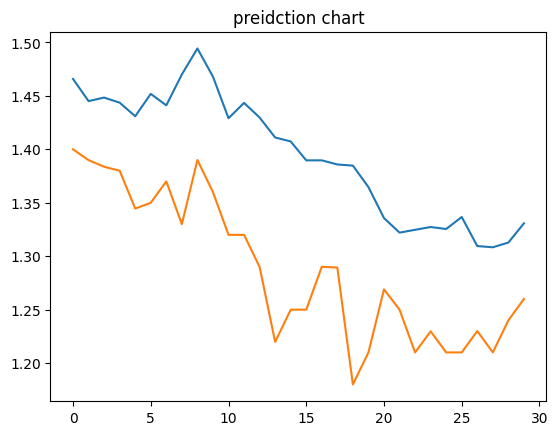

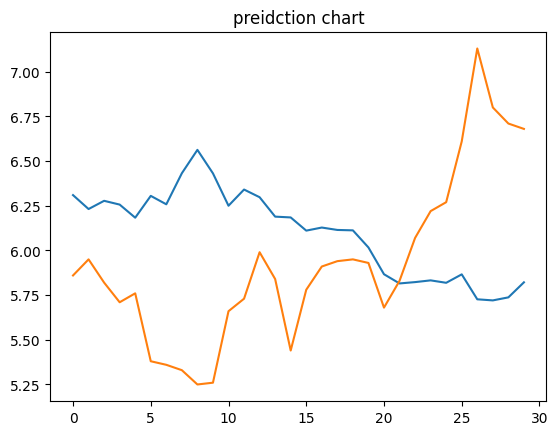

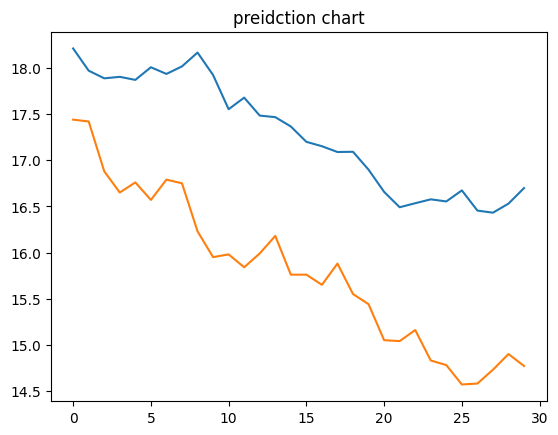

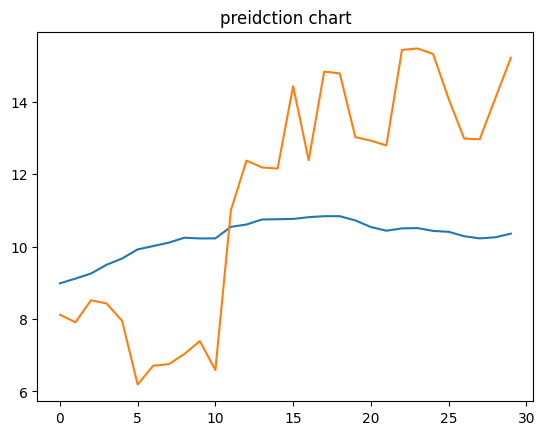

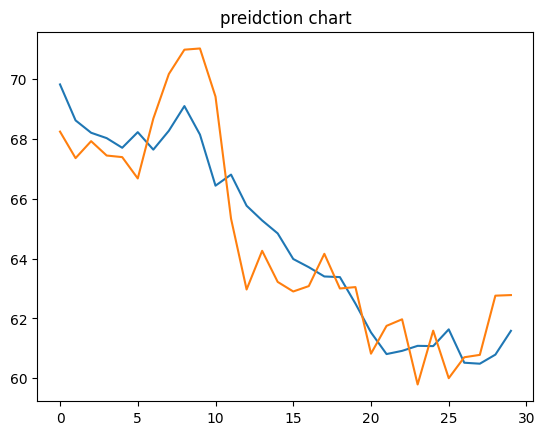

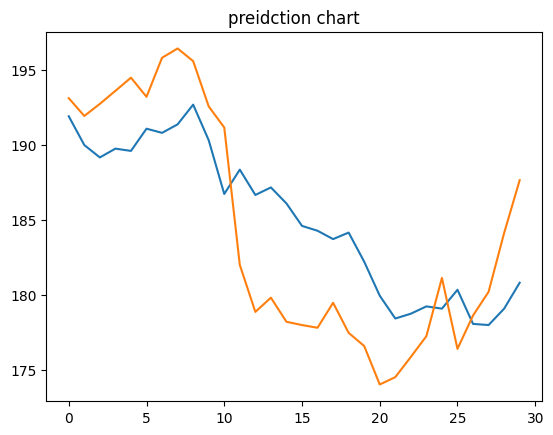

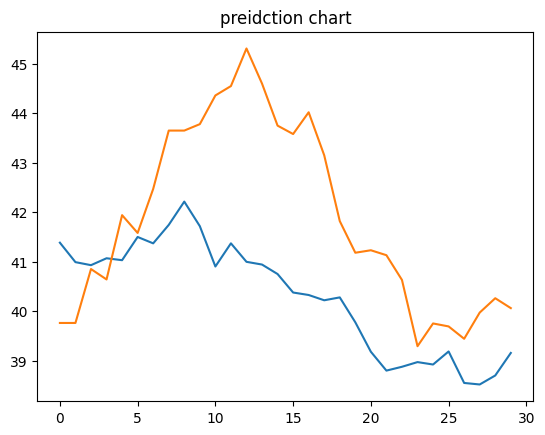

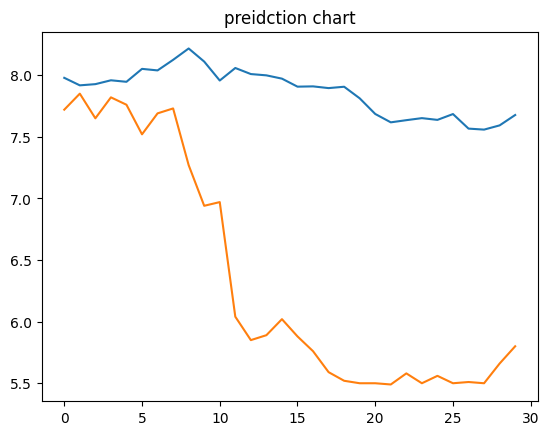

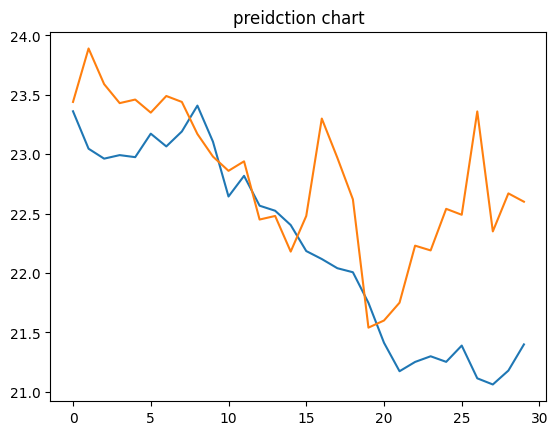

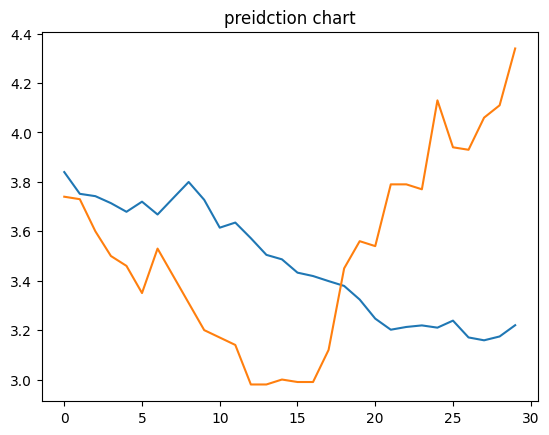

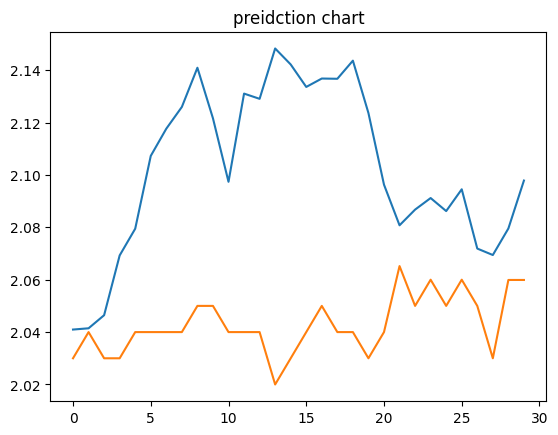

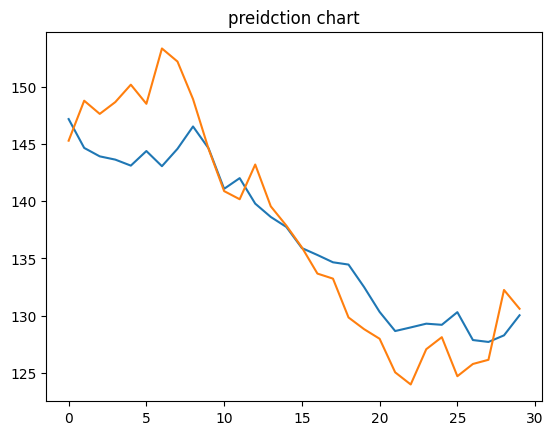

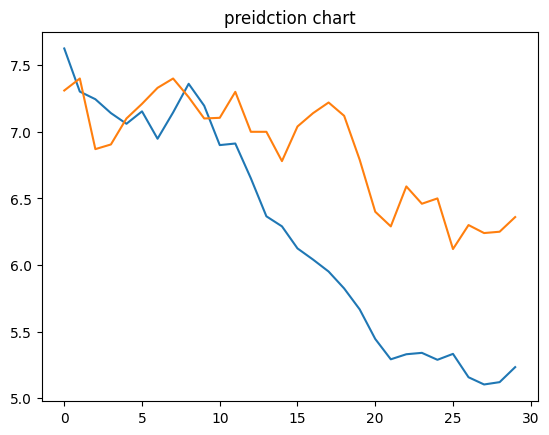

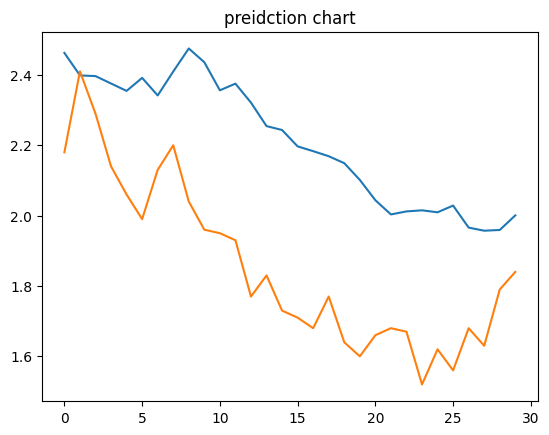

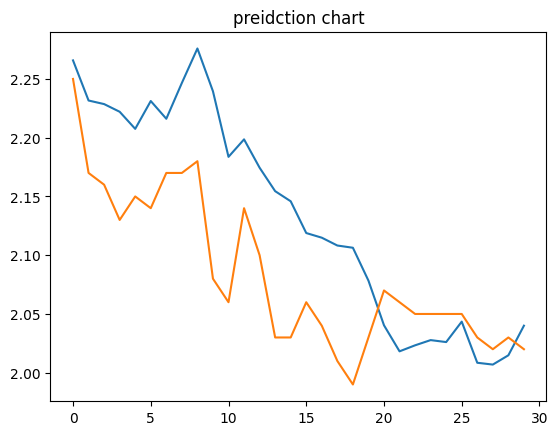

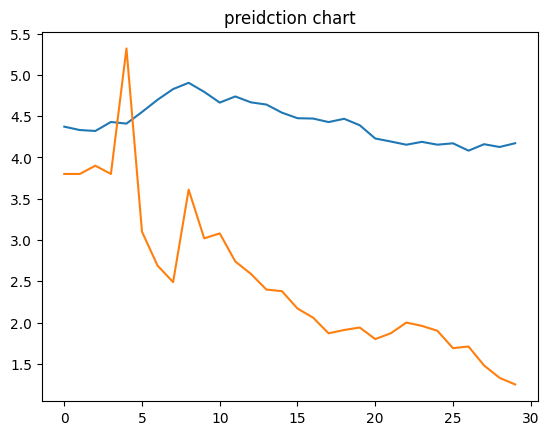

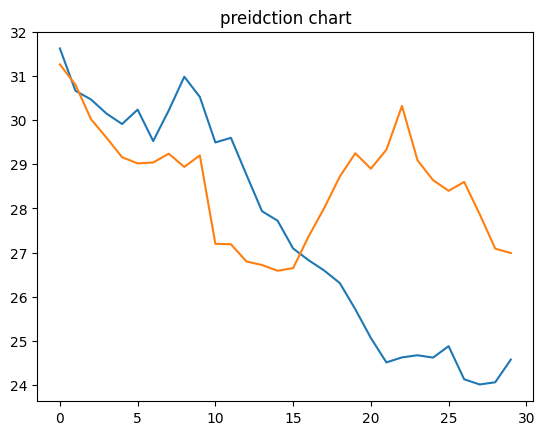

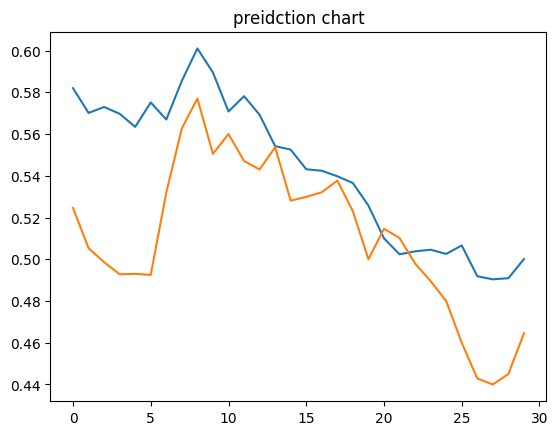

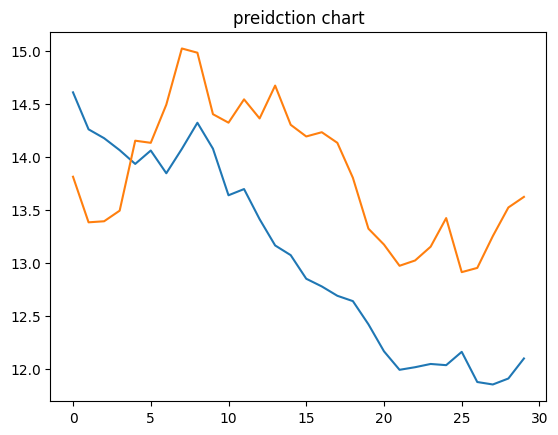

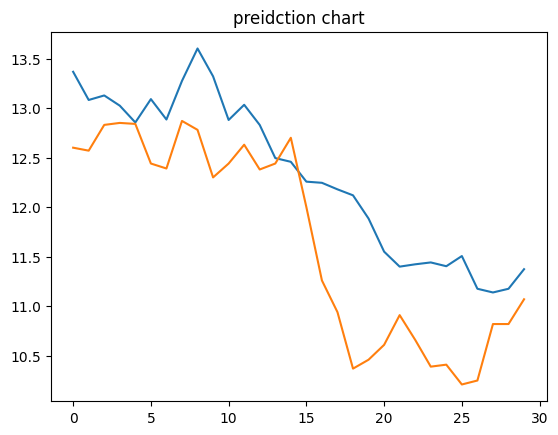

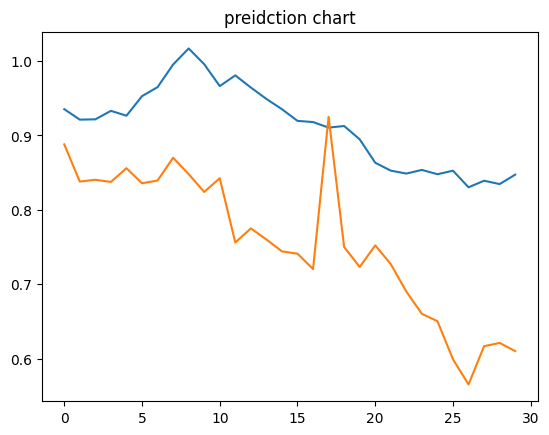

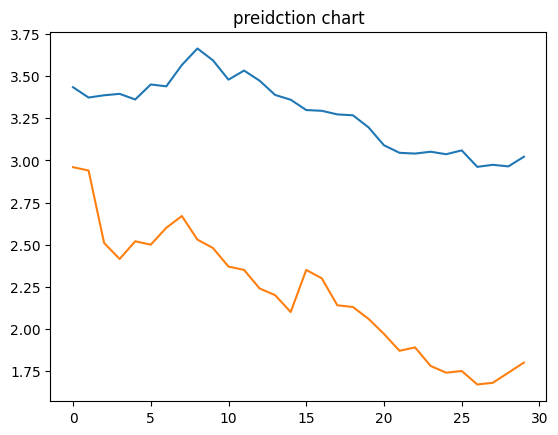

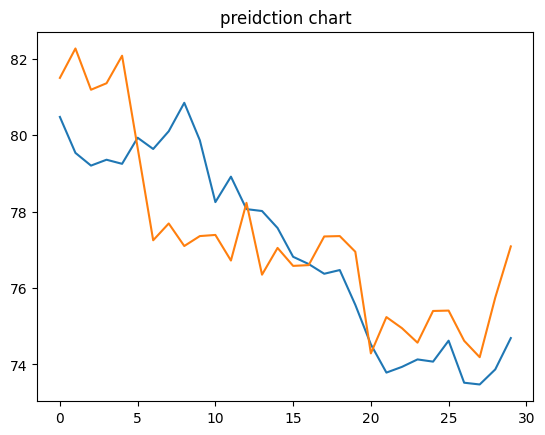

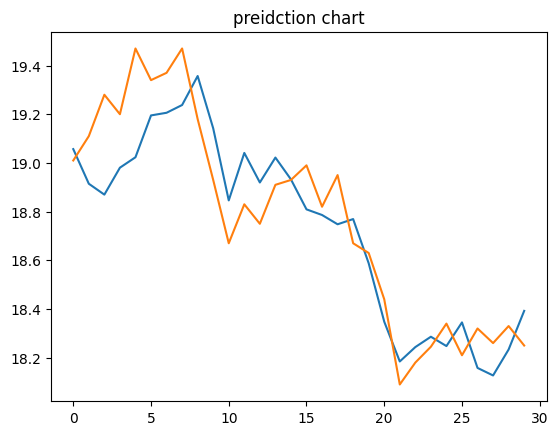

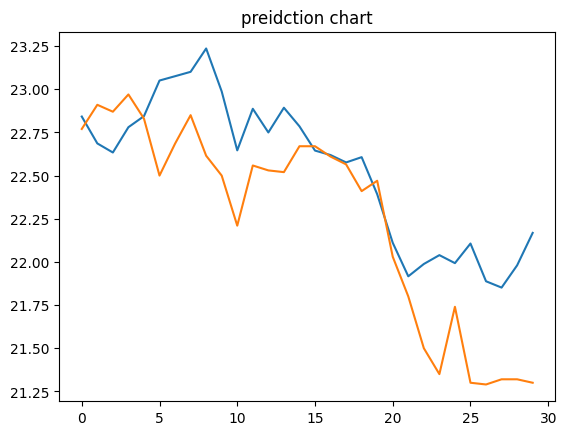

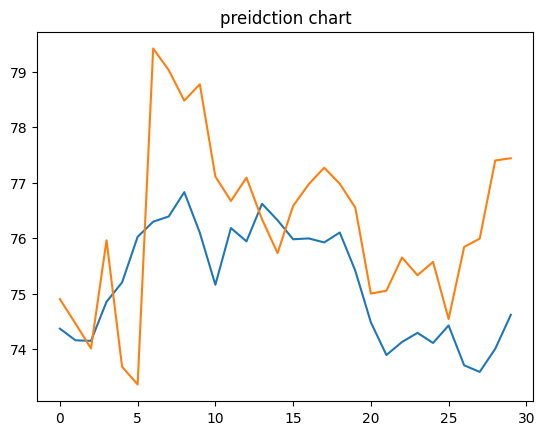

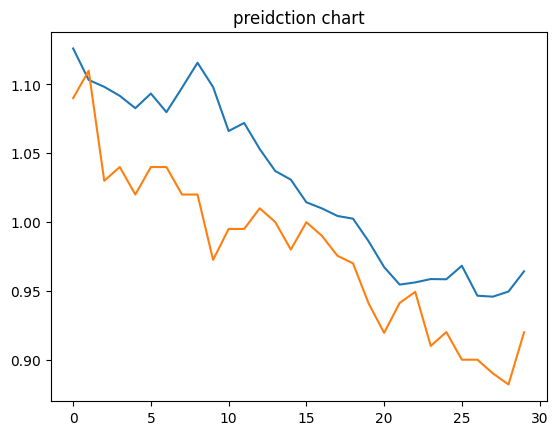

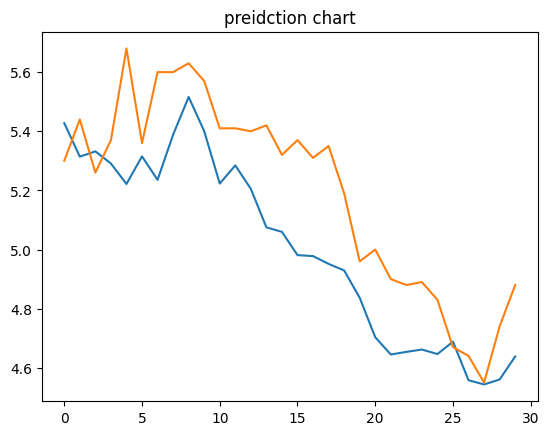

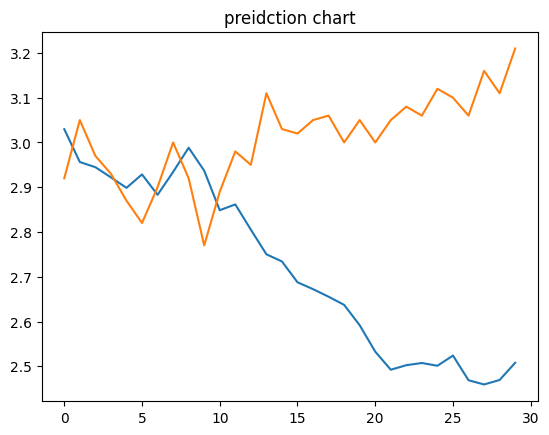

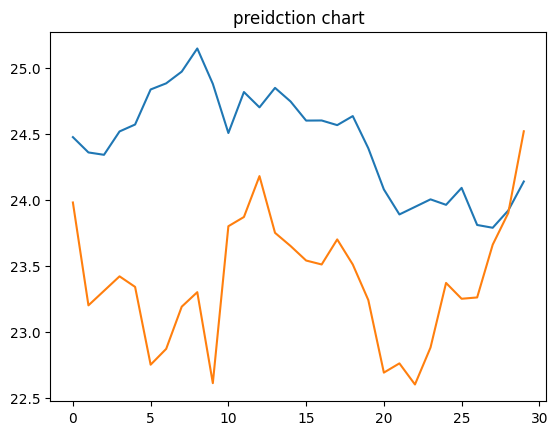

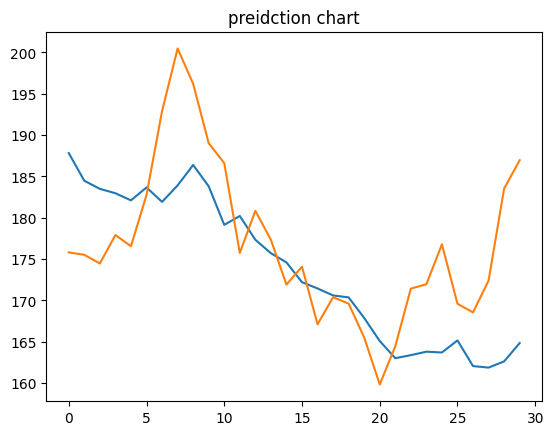

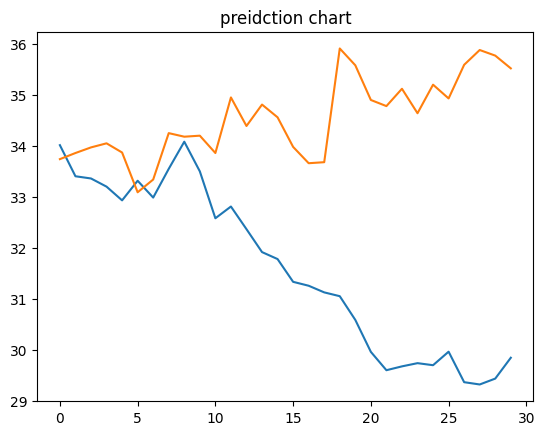

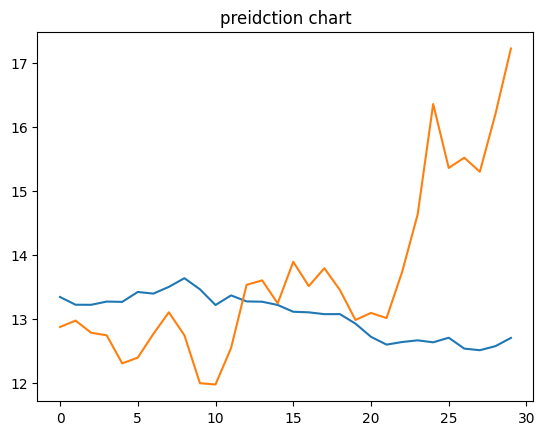

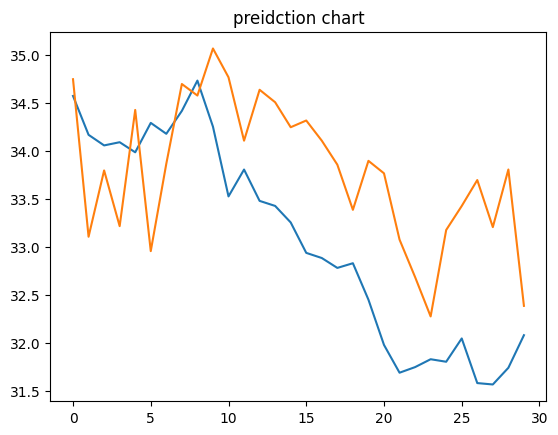

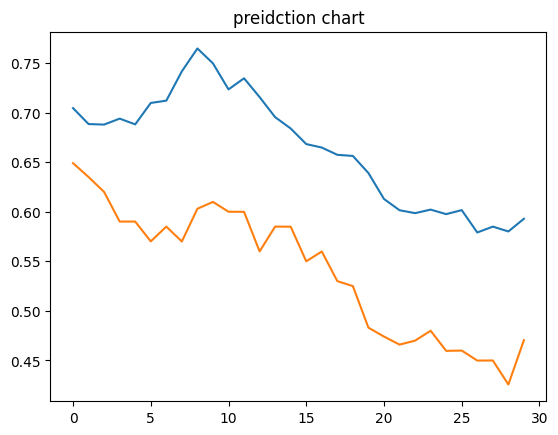

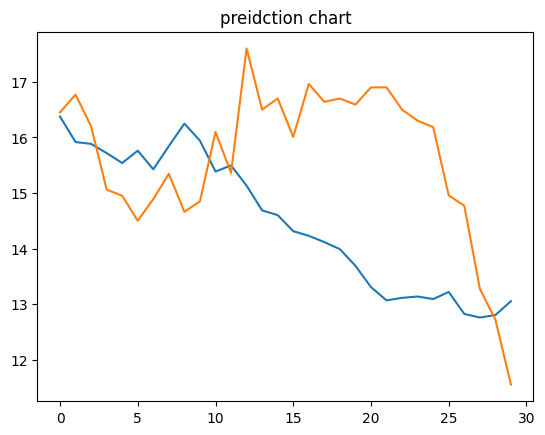

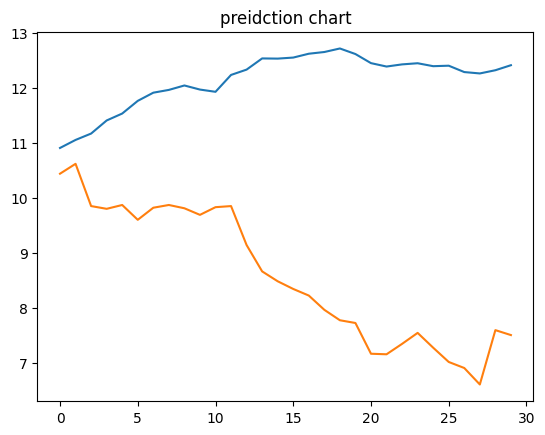

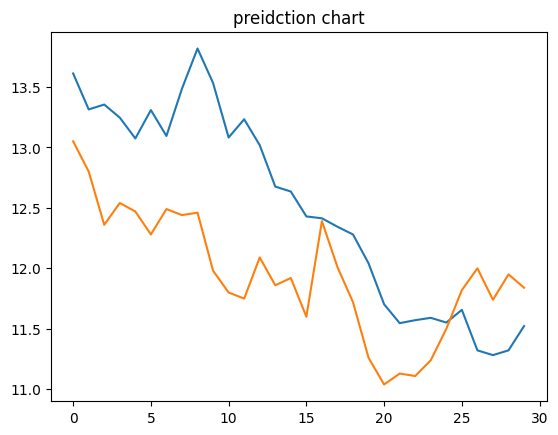

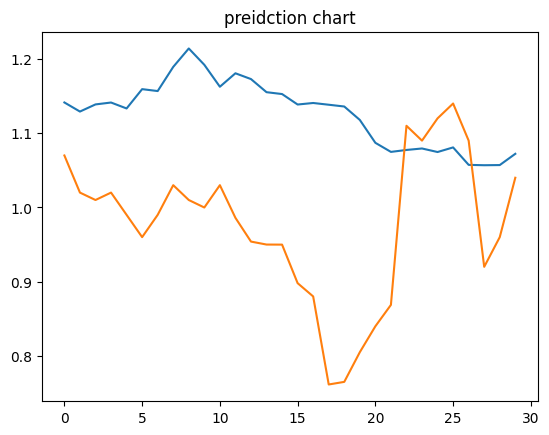

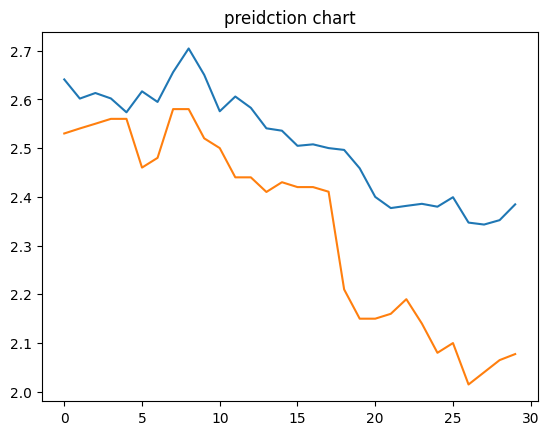

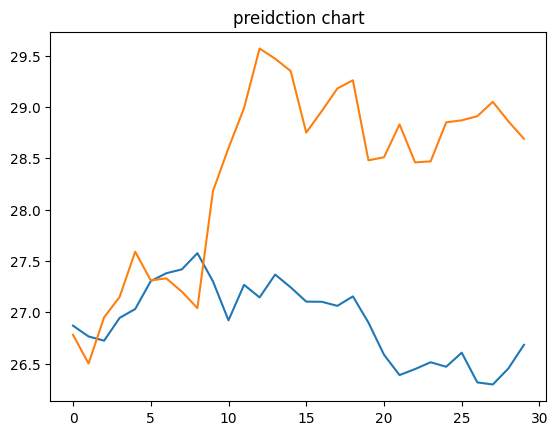

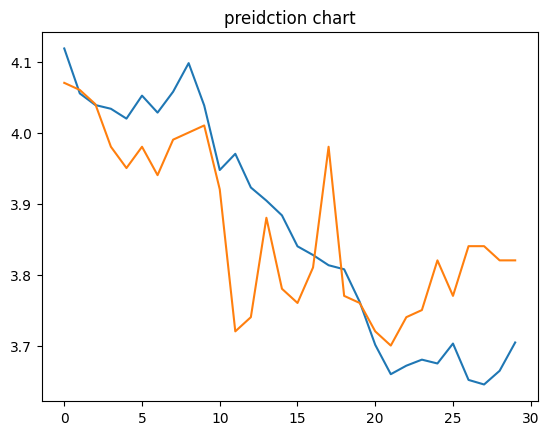

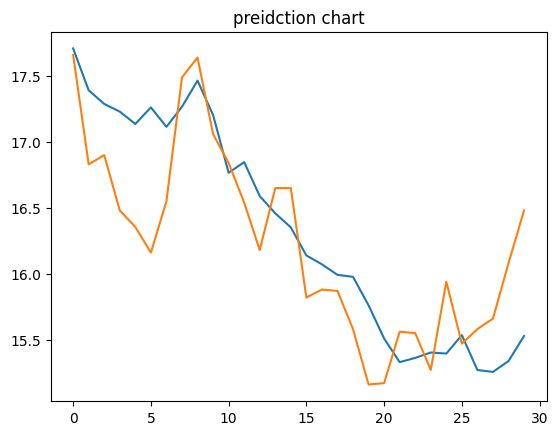

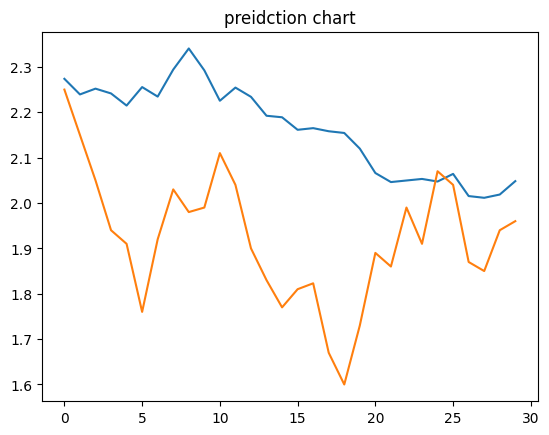

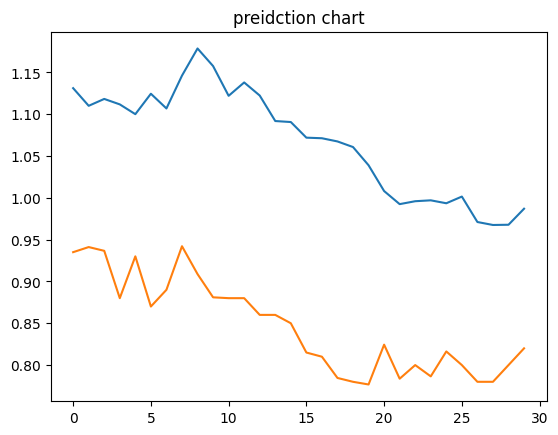

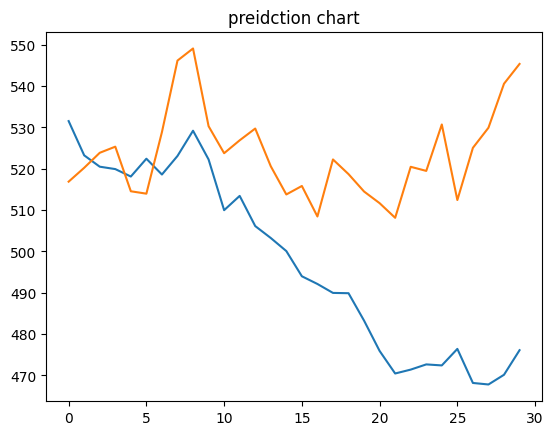

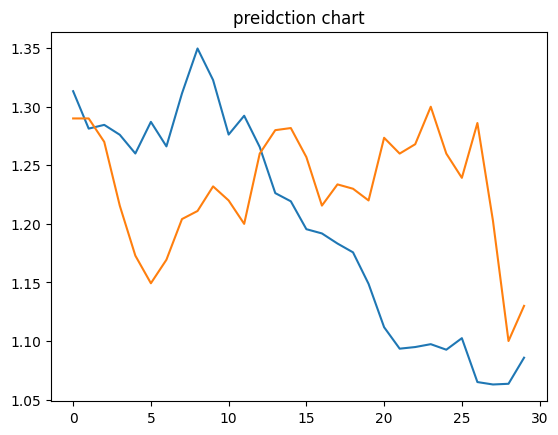

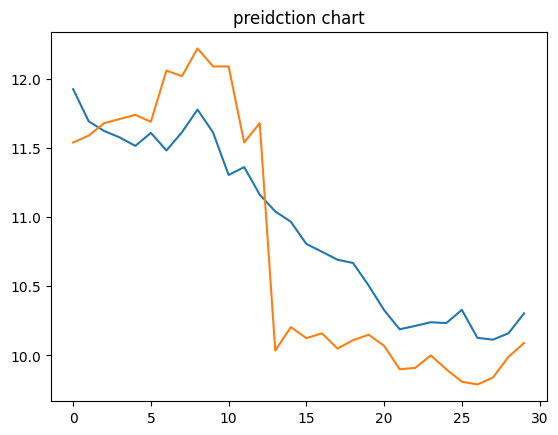

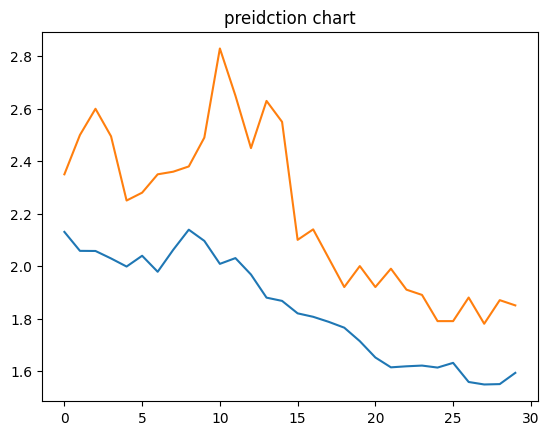

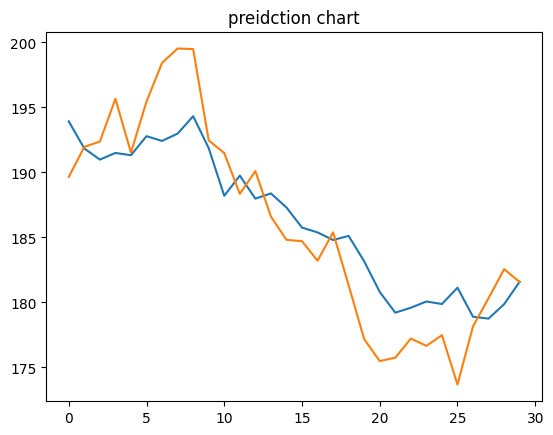

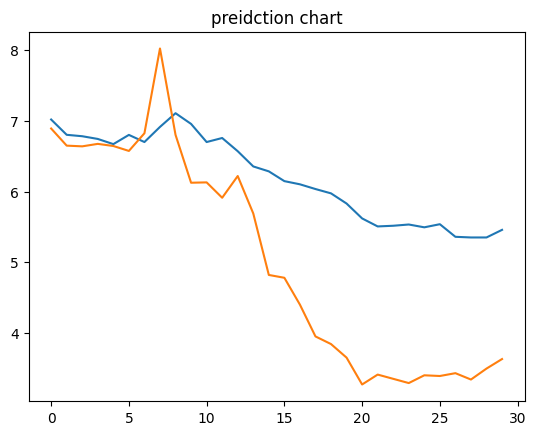

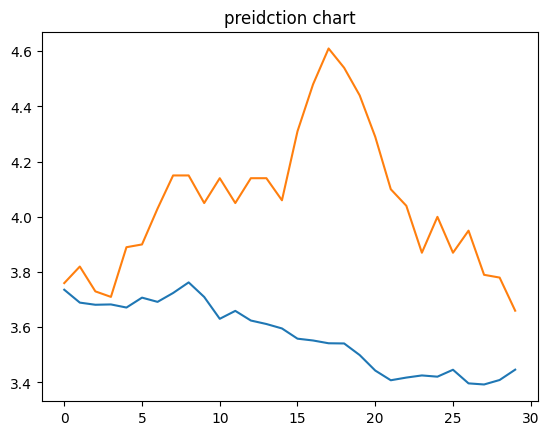

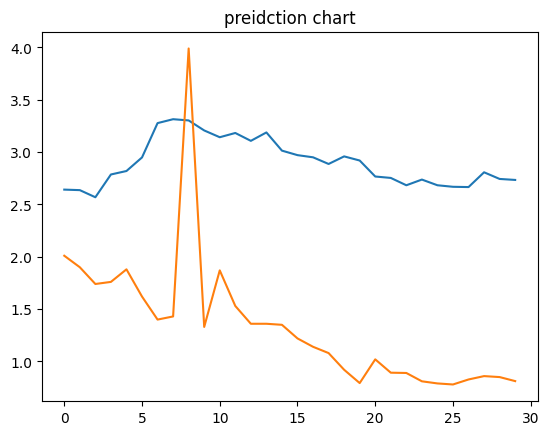

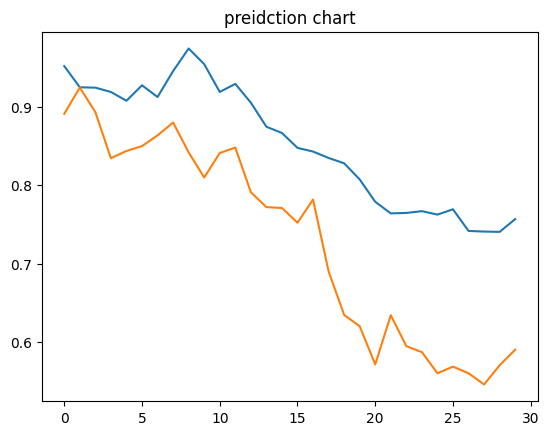

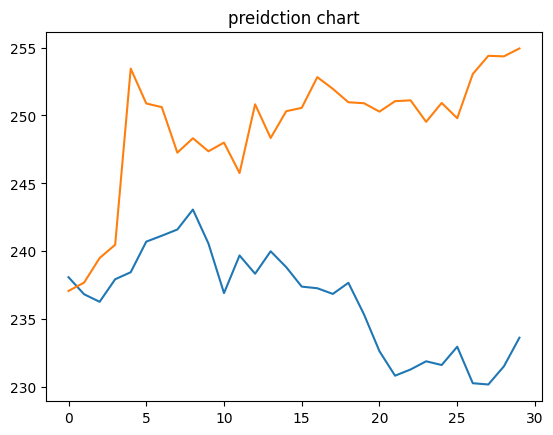

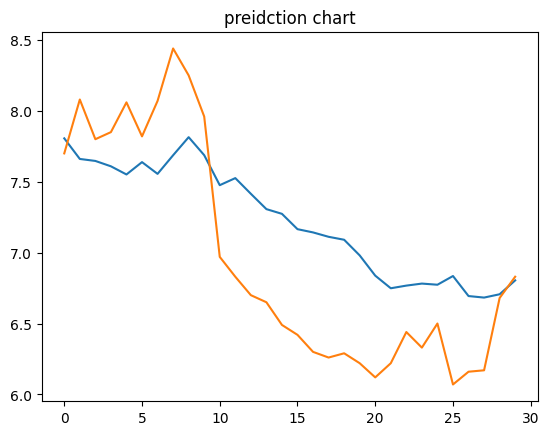

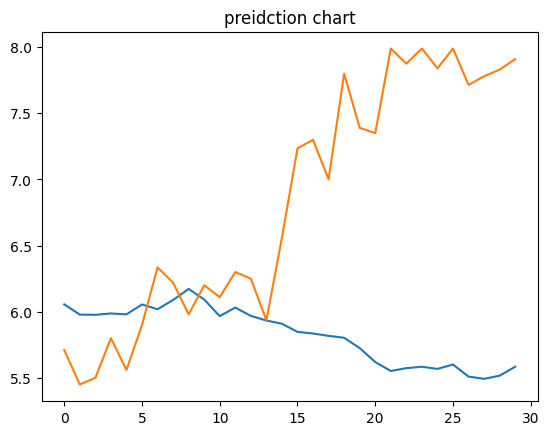

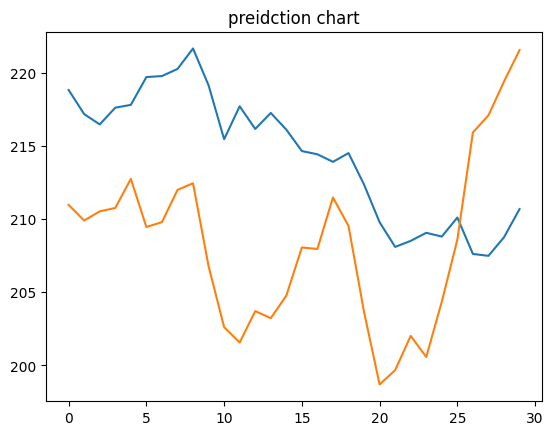

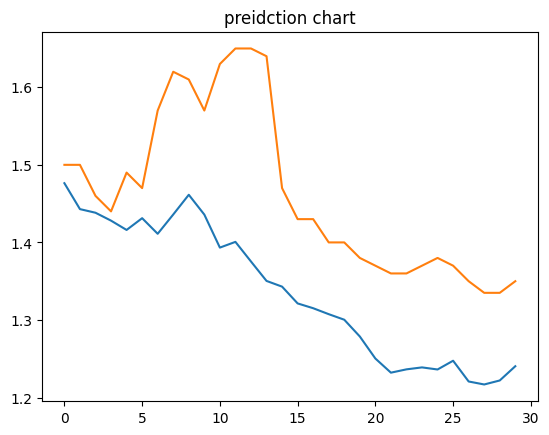

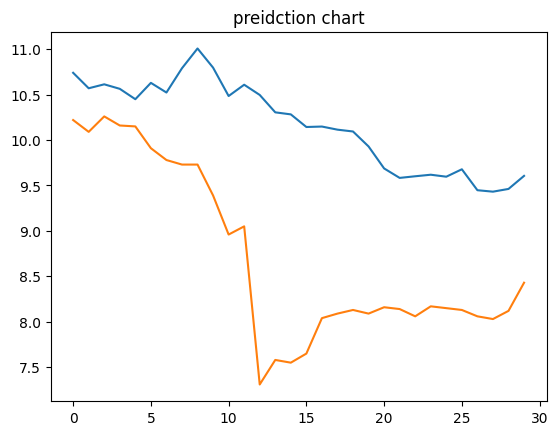

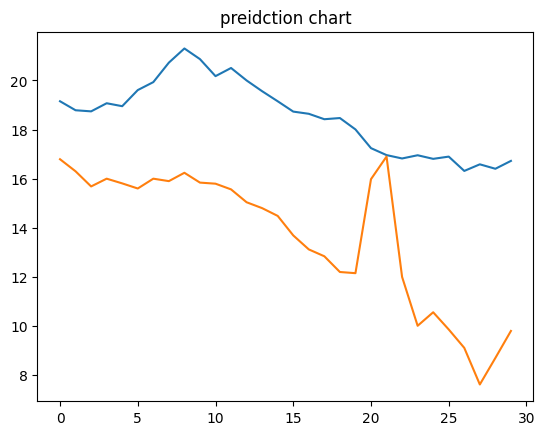

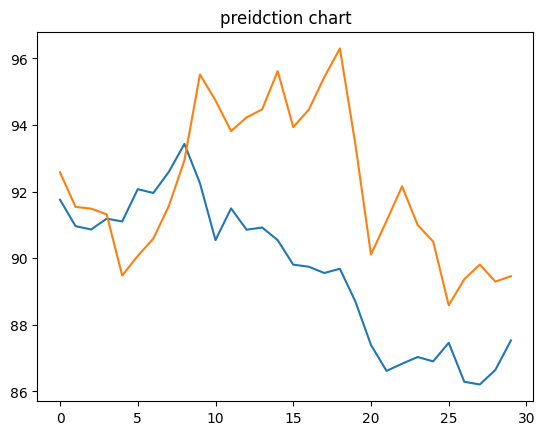

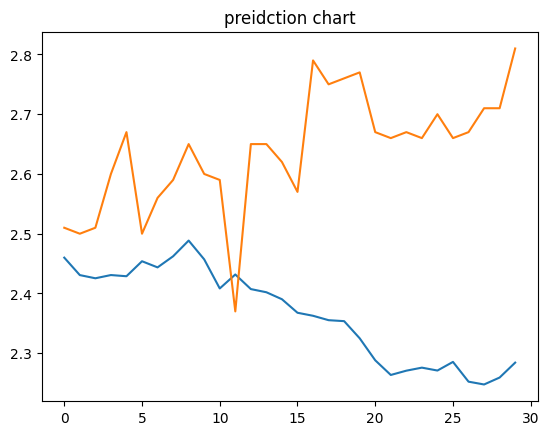

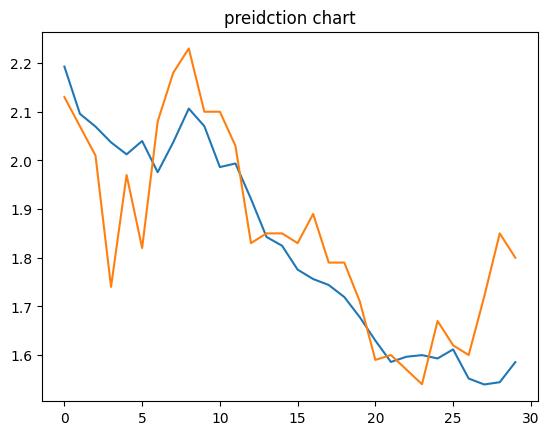

In [149]:
draw_predict(trainer)

In [ ]:
lstm = nn.LSTM(4,20,batch_first=True).cuda()
inputs.cuda()
